<a href="https://colab.research.google.com/github/RBorczuch/PlatesOCR/blob/main/PlatesOCR_model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np

# Define paths to the directories
input_dir = '/content/extracted_objects'
output_dir = '/content/extracted_objects_p'

# Ensure the output directory exists
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Function to apply histogram equalization
def equalize_histogram_color(image):
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image to different channels
    l, a, b = cv2.split(lab)

    # Apply histogram equalization on the L-channel
    l_eq = cv2.equalizeHist(l)

    # Merge the channels back
    lab_eq = cv2.merge((l_eq, a, b))

    # Convert back to BGR color space
    image_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    return image_eq

# Function to process images
def process_images(input_dir, output_dir):
    for image_name in os.listdir(input_dir):
        image_path = os.path.join(input_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image not found or unable to load: {image_path}")
            continue

        # Apply histogram equalization
        image_eq = equalize_histogram_color(image)

        # Convert to grayscale
        gray_image = cv2.cvtColor(image_eq, cv2.COLOR_BGR2GRAY)

        # Threshold the image to get only black areas
        _, thresh_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY_INV)

        # Create a mask for the black areas
        mask = cv2.inRange(image_eq, (0, 0, 0), (130, 200, 200))

        # Set all non-black areas to white
        image_eq[mask == 0] = [255, 255, 255]
        image_eq = cv2.cvtColor(image_eq, cv2.COLOR_BGR2GRAY)

        # Resize the image to 200x50 pixels
        resized_image = cv2.resize(image_eq, (200, 50))

        # Save the processed image
        output_path = os.path.join(output_dir, image_name)
        cv2.imwrite(output_path, resized_image)
        print(f"Saved processed image to {output_path}")

# Process images
process_images(input_dir, output_dir)

print("Images processed and saved successfully.")


Saved processed image to /content/extracted_objects_p/object_179_1_176.jpg
Images processed and saved successfully.


1/1 [==============================] - 2s 2s/step


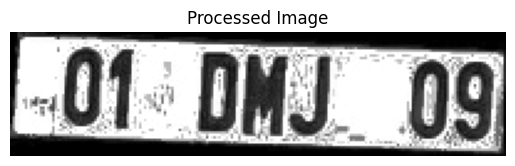

Prediction 0: 01DMJ09 


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Klasa CTCLayer zdefiniowana zgodnie z modelem
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

# Definicja nowych wymiarów obrazów
img_width = 200
img_height = 50

# Funkcja do przetwarzania obrazu
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    img = tf.expand_dims(img, axis=0)  # Dodanie wymiaru batch
    return img

# Funkcja do dekodowania wyników
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    decoded = keras.backend.get_value(results)
    return decoded

def load_and_predict(model_path, image_path, char_to_num, num_to_char):
    # Ładowanie modelu
    model = keras.models.load_model(model_path, custom_objects={'CTCLayer': CTCLayer})

    # Stworzenie modelu do predykcji (bez warstwy CTC)
    prediction_model = keras.models.Model(
        model.get_layer(name="image").input, model.get_layer(name="dense2").output
    )

    # Przetwarzanie obrazu
    input_img = preprocess_image(image_path)

    # Wykonywanie prognozy
    predictions = prediction_model.predict(input_img)

    # Dekodowanie wyników
    decoded_predictions = decode_batch_predictions(predictions)

    return decoded_predictions

# Przykład użycia
if __name__ == "__main__":
    model_path = '/content/best_model.h5'
    image_path = '/content/extracted_objects_p/object_179_1_176.jpg'

    # Utwórz zbiór unikalnych znaków z etykiet (zgodnie z treningiem)
    characters = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'Z', ' ']

    # Mapping characters to integers
    char_to_num = layers.StringLookup(
        vocabulary=list(characters), mask_token=None
    )

    # Mapping integers back to original characters
    num_to_char = layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

    # Załaduj model i wykonaj predykcję
    decoded_predictions = load_and_predict(model_path, image_path, char_to_num, num_to_char)


    # Usunięcie wymiaru wsadowego z input_img
    image = tf.squeeze(input_img)

    # Obrócenie obrazka o -90 stopni
    rotated_image = rotate(image, -90)

    # Wyświetlenie obróconego obrazka
    plt.imshow(rotated_image, cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')
    plt.show()

    # Wyświetl predykcje
    for i, pred in enumerate(decoded_predictions):
        pred_text = ''.join([num_to_char(idx).numpy().decode('utf-8') for idx in pred if idx != -1])
        print(f"Prediction {i}: {pred_text}")
